In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nltk
import numpy as np
nltk.download('punkt')
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

def tokenize(sentence):
    return nltk.word_tokenize(sentence)

def stem(word):
    return stemmer.stem(word.lower())

def bag_of_words(tokenized_sentence, all_words):
    tokenized_sentence = [stem(w) for w in tokenized_sentence]
    bag=np.zeros(len(all_words),dtype = np.float32)
    for idx, w in enumerate(all_words):
        if w in tokenized_sentence:
            bag[idx]=1.0
    return bag

import torch
import torch.nn as nn
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1= nn.Linear(input_size, hidden_size)
        self.l2= nn.Linear(hidden_size, hidden_size)
        self.l3= nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self,x):
        out= self.l1(x)
        out = self.relu(out)
        out= self.l2(out)
        out = self.relu(out)
        out= self.l3(out)
        return out


import json
import numpy as np
#from project import tokenize, stem, bag_of_words
import torch
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset

#from model import NeuralNet

with open('/content/drive/MyDrive/intents4.json','r') as f:
    intents = json.load(f)

all_words=[]
tags = []
xy = []
for intent in intents['intents']:
    tag=intent['tag']
    tags.append(tag)
    for pattern in intent['patterns']:
       w=tokenize(pattern)
       all_words.extend(w)
       xy.append((w,tag))

ignore_words = ['?','!','.',',']
all_words = [stem(w) for w in all_words if w not in ignore_words]
all_words = sorted(set(all_words))
tags = sorted(set(tags))

xtrain=[]
ytrain=[]

for(pattern_sentence, tag) in xy:
    bag= bag_of_words(pattern_sentence, all_words)
    xtrain.append(bag)
    label = tags.index(tag)
    ytrain.append(label)

xtrain=np.array(xtrain)
ytrain=np.array(ytrain)

class ChatDataset(Dataset):
    def __init__(self): # Corrected to __init__
        self.n_samples=len(xtrain)
        self.xdata=xtrain
        self.ydata=ytrain

    #dataset[idx]
    def __getitem__(self, index): # Corrected to __getitem__
        return self.xdata[index],self.ydata[index]
    def __len__(self): # Corrected to __len__
        return self.n_samples

batch_size=8
hidden_size = 8
output_size = len(tags)
input_size = len(xtrain[0])
learning_rate = 0.001
num_epochs = 1000


dataset=ChatDataset()
train_loader= DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=2)

device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=NeuralNet(input_size, hidden_size, output_size).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for(words, labels) in train_loader:
        words = words.to(device)
        labels = labels.to(device)
        output = model(words)
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if(epoch+1)%100 == 0:
        print(f'epoch = {epoch+1}/{num_epochs} , LOSS = {loss.item():.4f}')


print(f'Final Loss, loss={loss.item():.4f}')
data = {
    "model_state" : model.state_dict(),
    "input_size" : input_size,
    "output_size" : output_size,
    "hidden_size" : hidden_size,
    "all_words" : all_words,
    "tags" : tags
}

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


epoch = 100/1000 , LOSS = 0.0207
epoch = 200/1000 , LOSS = 0.0017
epoch = 300/1000 , LOSS = 0.0004
epoch = 400/1000 , LOSS = 0.0001
epoch = 500/1000 , LOSS = 0.0000
epoch = 600/1000 , LOSS = 0.0000
epoch = 700/1000 , LOSS = 0.0000
epoch = 800/1000 , LOSS = 0.0000
epoch = 900/1000 , LOSS = 0.0000
epoch = 1000/1000 , LOSS = 0.0000
Final Loss, loss=0.0000


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Epoch [100/500], Loss: 0.0398, Accuracy: 100.00%
Epoch [200/500], Loss: 0.0053, Accuracy: 100.00%
Epoch [300/500], Loss: 0.0007, Accuracy: 100.00%
Epoch [400/500], Loss: 0.0001, Accuracy: 100.00%
Epoch [500/500], Loss: 0.0000, Accuracy: 100.00%
Final Loss: 0.0000


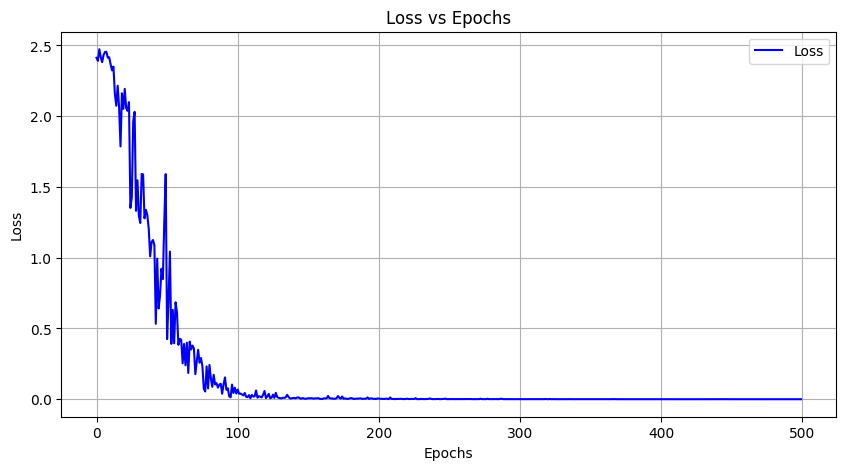

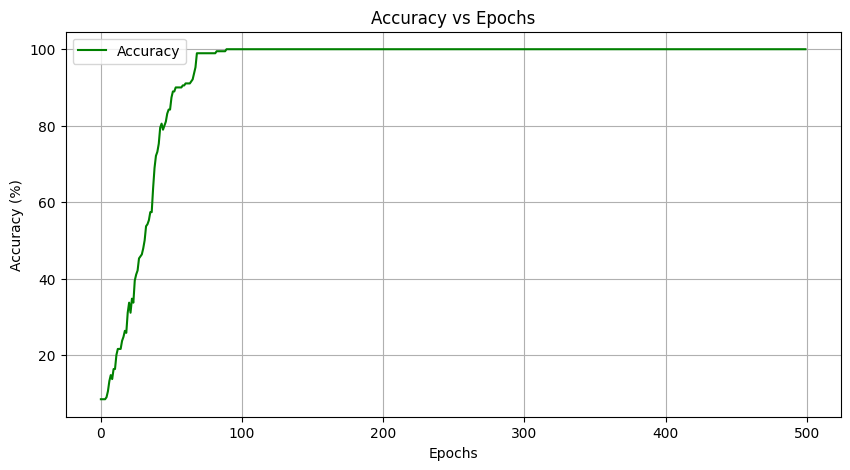

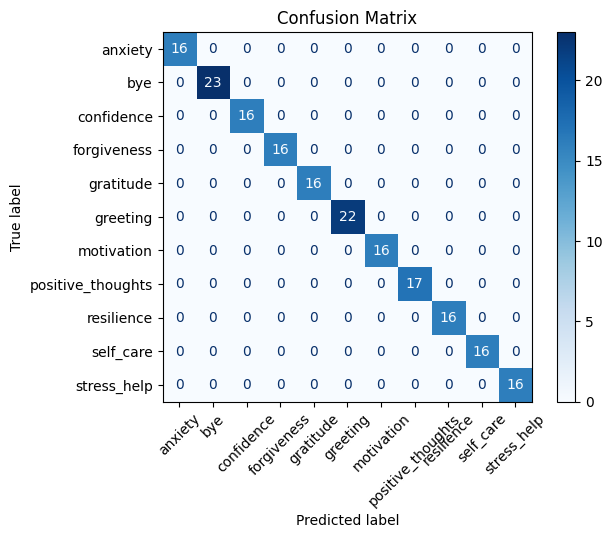

In [ ]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

nltk.download('punkt')
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()

# Functions for tokenizing, stemming, and creating bag of words
def tokenize(sentence):
    return nltk.word_tokenize(sentence)

def stem(word):
    return stemmer.stem(word.lower())

def bag_of_words(tokenized_sentence, all_words):
    tokenized_sentence = [stem(w) for w in tokenized_sentence]
    bag = np.zeros(len(all_words), dtype=np.float32)
    for idx, w in enumerate(all_words):
        if w in tokenized_sentence:
            bag[idx] = 1.0
    return bag

# Neural Network Model
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        return out

# Load intents JSON data
import json

with open('/content/drive/MyDrive/intents4.json', 'r') as f:
    intents = json.load(f)

# Preprocessing the data
all_words = []
tags = []
xy = []

for intent in intents['intents']:
    tag = intent['tag']
    tags.append(tag)
    for pattern in intent['patterns']:
        w = tokenize(pattern)
        all_words.extend(w)
        xy.append((w, tag))

ignore_words = ['?', '!', '.', ',']
all_words = [stem(w) for w in all_words if w not in ignore_words]
all_words = sorted(set(all_words))
tags = sorted(set(tags))

xtrain = []
ytrain = []

for (pattern_sentence, tag) in xy:
    bag = bag_of_words(pattern_sentence, all_words)
    xtrain.append(bag)
    label = tags.index(tag)
    ytrain.append(label)

xtrain = np.array(xtrain)
ytrain = np.array(ytrain)

# Custom Dataset class
class ChatDataset(Dataset):
    def __init__(self):
        self.n_samples = len(xtrain)
        self.xdata = xtrain
        self.ydata = ytrain

    def __getitem__(self, index):
        return self.xdata[index], self.ydata[index]

    def __len__(self):
        return self.n_samples

# Hyperparameters
batch_size = 8
hidden_size = 8
output_size = len(tags)
input_size = len(xtrain[0])
learning_rate = 0.001
num_epochs = 500

# DataLoader
dataset = ChatDataset()
train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralNet(input_size, hidden_size, output_size).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Variables for tracking metrics
losses = []
accuracies = []

# Training Loop
for epoch in range(num_epochs):
    correct = 0
    total = 0
    for words, labels in train_loader:
        words = words.to(device)
        labels = labels.to(device)

        # Forward pass
        output = model(words)
        loss = criterion(output, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(output, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Record loss and accuracy
    losses.append(loss.item())
    accuracy = 100 * correct / total
    accuracies.append(accuracy)

    # Print progress every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%')

print(f'Final Loss: {loss.item():.4f}')

# ============================
# Generate Graphs
# ============================

# Plot 1: Loss vs. Epochs
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), losses, label='Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.grid(True)
plt.legend()
plt.show()

# Plot 2: Accuracy vs. Epochs
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), accuracies, label='Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.grid(True)
plt.legend()
plt.show()

# Confusion Matrix
def plot_confusion_matrix(model, data_loader):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for words, labels in data_loader:
            words = words.to(device)
            labels = labels.to(device)
            output = model(words)
            _, predicted = torch.max(output, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tags)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title('Confusion Matrix')
    plt.show()

# Plot 3: Confusion Matrix
plot_confusion_matrix(model, train_loader)


In [ ]:
import random
FILE = "data.pth"
#torch.save(FILE)
torch.save(data, FILE)
print(f'Train complete, file saved to {FILE}')

input_size = data["input_size"]
hidden_size = data["hidden_size"]
output_size = data["output_size"]
all_words = data["all_words"]
tags = data["tags"]
model_state = data["model_state"]
model=NeuralNet(input_size, hidden_size, output_size).to(device)
model.load_state_dict(model_state)
model.eval()

bot_name = "LUFFY"
print("Lets Chat! Type 'quit' to exit")
while(True):
    sentence = input("You: ")
    if sentence=="quit":
        break

    sentence = tokenize(sentence)
    x= bag_of_words(sentence, all_words)
    x = x.reshape(1, x.shape[0])
    x=torch.from_numpy(x).to(device) # Move x to the same device as the model
    output = model(x)
    _, predicted = torch.max(output, dim=1)
    tag = tags[predicted.item()]

    probs= torch.softmax(output, dim=1)
    probs = probs[0][predicted.item()]
    if probs.item() > 0.75: # Access the value using .item()
      for intent in intents["intents"]:
        if tag==intent["tag"]:
           print(f"{bot_name}: {random.choice(intent['responses'])}") # Import random
    else:
        print(f"{bot_name}: I dont understand.......")

Train complete, file saved to data.pth
Lets Chat! Type 'quit' to exit
LUFFY: Every day is a fresh start, a new beginning.
LUFFY: A positive attitude causes a chain reaction of positive thoughts, events, and outcomes.
LUFFY: I dont understand.......
LUFFY: With confidence, you have won before you have started.
You: quit
